# Image Filtering

In our previous notebook, we saw that we need computer vision algorithms that can extract information from information hidden in spatially varying signals, as most of the image information lay in the frequency, not amplitude (or intensity) of the image pixels. 

In our lectures this week, we introduced a filtering view to images, using the convolution operation. You'll implement this operation yourselves in a lab, but today we are going to try out some useful hand-designed filters. Later on in this unit, you will explore convolutional neural networks to perform more complex operations like image classification and object detection. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from IPython import display

In [2]:
# I'll load in my own test image, swap this for one of your own
im = cv2.imread('../test_images/Drone_1.jpg')

## The convolution operation
First, lets visualise the convolution operation using some inline plotting code. Lets imagine a square filter 200 pixels x 200 pixels sliding over our image. To make it simpler, I will make it jump ahead a few pixels at a time. We call this a strided convolution.

In [3]:
def plot_rectangle(i,j,w):
    plt.plot([i-w,i-w],[j-w,j+w],'k--')
    plt.plot([i+w,i+w],[j-w,j+w],'k--')
    plt.plot([i-w,i+w],[j-w,j-w],'k--')
    plt.plot([i-w,i+w],[j+w,j+w],'k--')

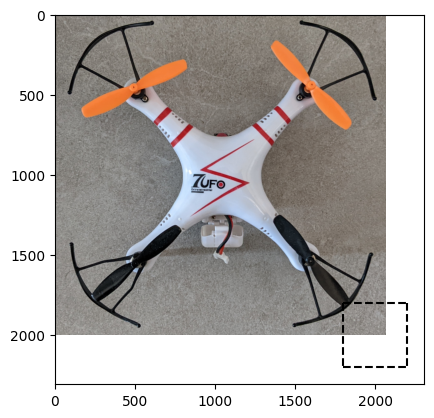

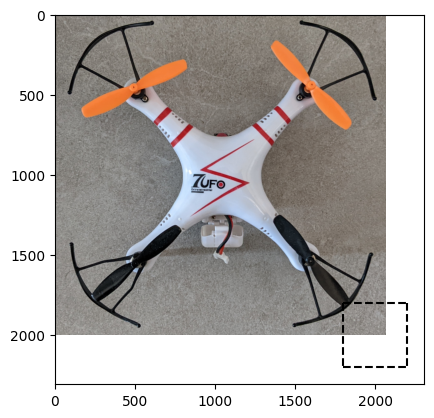

In [5]:
w = 200
for row in np.linspace(0,im.shape[0],10,dtype=int):
    for col in np.linspace(0,im.shape[0],10,dtype=int):
        plt.clf() # clear the figure
        plt.imshow(im[:,:,[2,1,0]])
        plot_rectangle(col,row,w)
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

The convolution operation slides a mask, kernel or filter over the image, multiplies it with the pixel values under the mask, and sums these to produce an output response at a pixel location. 

We can immediately see a challenge you'll encounter when you implement your own convolution - how do we handle pixels outside the image? For the remainder of this lecture though, we'll use a built in convolution function from opencv. Lets start by implementing the averaging filter we saw in the lectures.

To make things easier - we'll convert our image to a single channel grayscale image. I will also resize the image to make it a little smaller.

#### Some homework - think about how you could resize an image using a convolution operation?

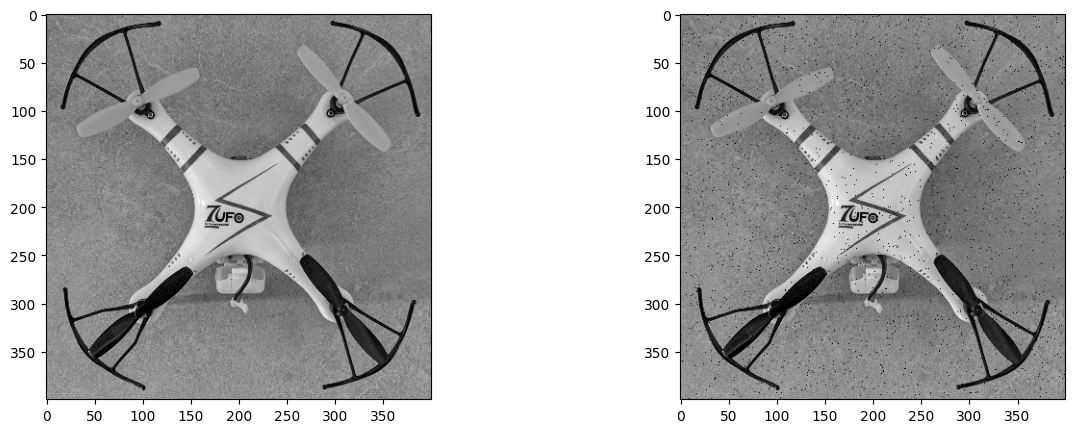

In [6]:
im_gray = cv2.cvtColor(cv2.resize(im,(400,400)), cv2.COLOR_BGR2GRAY)
 # Add some salt and pepper noise (missing values to 1 % of pixels)
im_gray_noisy = im_gray*(np.random.rand(im_gray.shape[0],im_gray.shape[1])>0.01)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_gray,cmap='gray') # see how my even resizing has distorted the image a bit?
plt.subplot(1,2,2)
plt.imshow(im_gray_noisy,cmap='gray') # see how my even resizing has distorted the image a bit?
plt.show()

Lets try to clean this up with an averaging filter, 3x3 pixels

In [7]:
kernel = 1/9*np.ones((3,3))

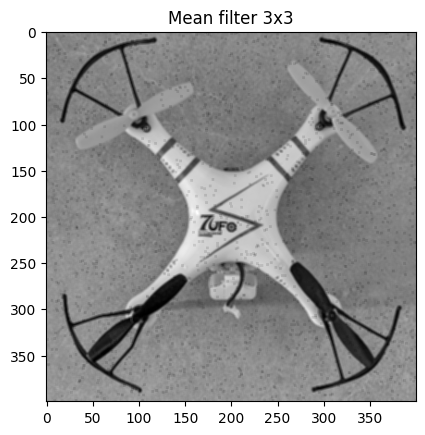

In [8]:
# Technically this is correlation, not convolution, but it doesn't matter with a symmetric kernel
response = cv2.filter2D(src=im_gray_noisy,ddepth=0,kernel=kernel)

plt.imshow(response,cmap='gray')
plt.title('Mean filter 3x3')
plt.show()

Hmm, not great those missing pixels are still visible. Our image is also a bit blurry now. Lets try a larger filter.

In [9]:
kernel = 1/(15*15)*np.ones((15,15))

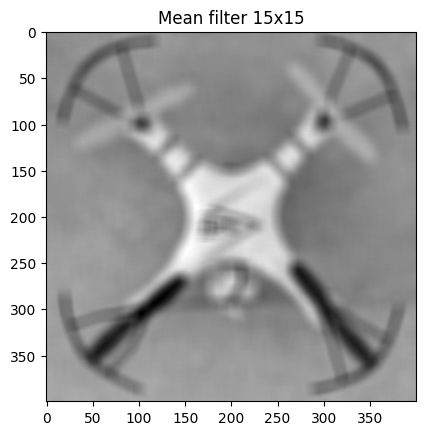

In [12]:
response = cv2.filter2D(src=im_gray_noisy,ddepth=0,kernel=kernel)

plt.imshow(response,cmap='gray')
plt.title('Mean filter 15x15')
plt.show()

Well, the noise is better, but the image looks quite blurry now. Lets try a median filter - we'll replace each pixel, by the most common in a set of blocks surrounding it. Unfortunately, this can't be represented that nicely using a convolution operation.

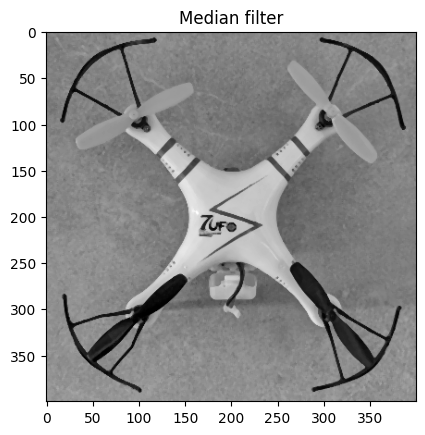

In [13]:
response = cv2.medianBlur(im_gray_noisy,ksize=3)

plt.imshow(response,cmap='gray')
plt.title('Median filter')
plt.show()

Looks better, although if you look closely you will find there are some interesting artifacts.

## Activity 1 

Modify the code above to replace the noise with thermal noise. Re-run the code and compare the median and mean filter approaches. Hint thermal noise looks like additive gaussian noise - np.random.randn() can be used to generate normally distributed noise

- Did the output change?
- What type of approach is best suited to the different types of noise?


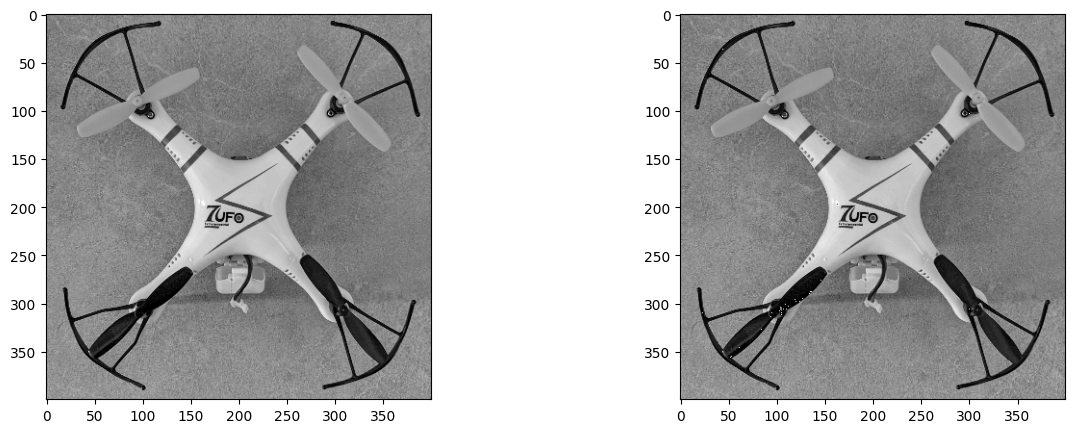

In [30]:
thermal_noise = np.random.randn(im_gray.shape[0], im_gray.shape[1])
 # Add some thermal
im_gray_thermal = im_gray + thermal_noise
im_gray_thermal = im_gray_thermal.astype(np.uint8)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_gray,cmap='gray') # see how my even resizing has distorted the image a bit?
plt.subplot(1,2,2)
plt.imshow(im_gray_thermal,cmap='gray') # see how my even resizing has distorted the image a bit?
plt.show()
# no difference because normal distribution has a mean of 0 and standard deviation of 1, pixel values in grayscale range from 0 to 255

## Combining filtering operations

Our averaging filter used a single kernel and convolution operation, but we can also chain a few of this together to produce more interesting responses. Let's see how we can use two Gaussian filters to build an edge detector using a difference of Gaussians approach.

In [32]:
def make_gaussian_kernel(d=15,sigma=3):
    xx,yy = np.meshgrid(np.arange(d),np.arange(d))
    f = 1.0/np.sqrt((2*np.pi)**2*sigma**2*sigma**2)*np.exp(-0.5*((xx-d/2)**2 + (yy-d/2)**2)/sigma**2)
    return f
# mesh grids are more efficent than for loops

Let start by building a 15x15 Gaussian kernel, with a standard deviation of 3

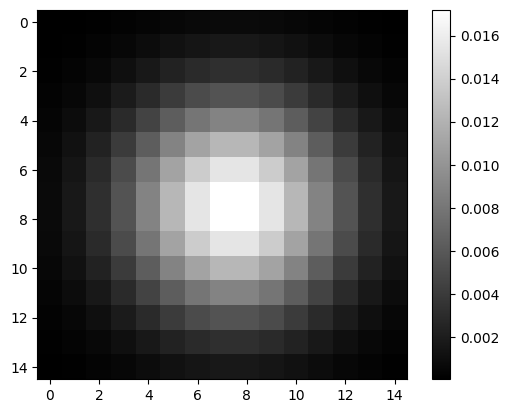

In [33]:
kernel = make_gaussian_kernel(15,3)
plt.imshow(kernel,cmap='gray')
plt.colorbar()
plt.show()

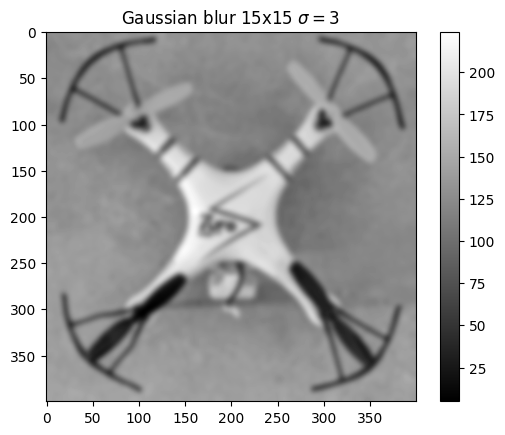

In [35]:
gaussian_response = cv2.filter2D(src=im_gray,ddepth=-1,kernel=kernel)

plt.imshow(gaussian_response,cmap='gray')
plt.title('Gaussian blur 15x15 $\sigma=3$')
plt.colorbar()
plt.show()

Some nice soft focus there. Lets convolve with a smaller standard deviation now, and subtract the two.

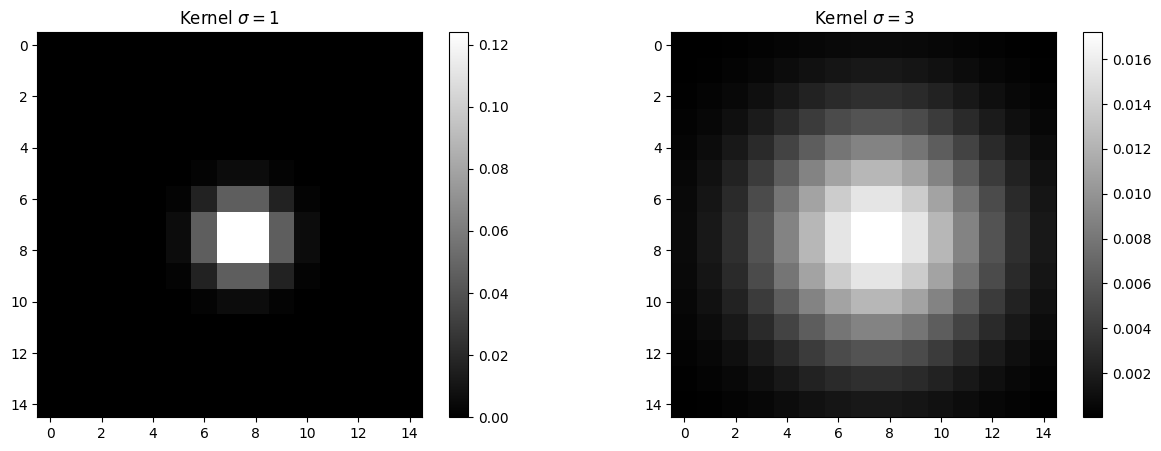

In [36]:
kernel_1 = make_gaussian_kernel(15,1)
kernel_3 = make_gaussian_kernel(15,3)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(kernel_1,cmap='gray')
plt.title("Kernel $\sigma=1$")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(kernel_3,cmap='gray')
plt.title("Kernel $\sigma=3$")
plt.colorbar()
plt.show()

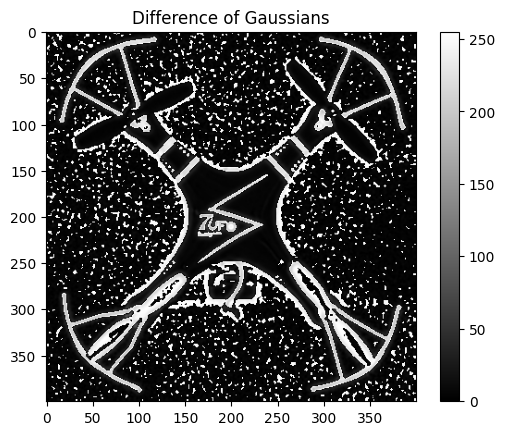

In [37]:
gaussian_response_1 = cv2.filter2D(src=im_gray,ddepth=-1,kernel=kernel_1)
gaussian_response_2 = cv2.filter2D(src=im_gray,ddepth=-1,kernel=kernel_3)

dog = gaussian_response_1-gaussian_response_2

plt.imshow(dog,cmap='gray')
plt.title('Difference of Gaussians')
plt.colorbar()
plt.show()
# similar to derivative of an image

Cool, we built an edge detector, using basic maths and two convolutional filters. We can start to build filters up to form more complicated responses, that extract targeted information. Later in this unit, you will see that convolutional neural networks and deep learning simply use multiple chained layers of these simple operations with learned filters to extract useful information from images. You'll also see a similar approach later in the unit when you use Haar wavelets to extract information for face detection.

### Activity 2 - Image sharpening

Write a small code snippet to add the edge response above to the original image and visualise the result. 

- What effect does this have?
- Does this create any unusual artifacts in your image?
- What happends to the texture in the background?

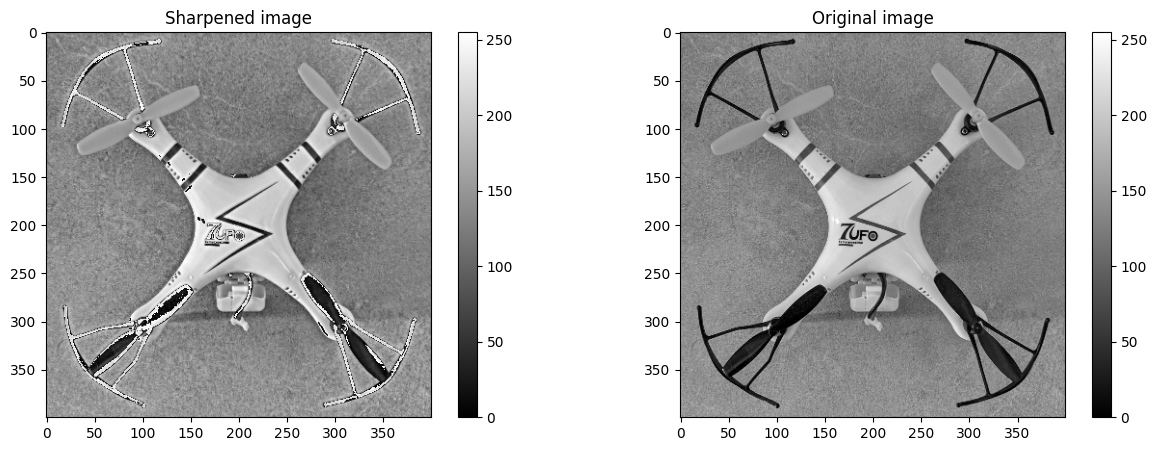

In [41]:
result_image = im_gray + dog

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(result_image,cmap='gray')
plt.colorbar()
plt.title('Sharpened image')
plt.subplot(1,2,2)
plt.imshow(im_gray,cmap='gray')
plt.title('Original image')
plt.colorbar()
plt.show()

### Keypoint detection and patch matching

In the labs, you will implement some Sobel filters for edge detection and corner detection. Keypoints are a useful representation that reduce the dimensionality of an image, while still retaining a lot of information. We'll use these a lot for homography estimation and 3D reconstruction approaches, and see some examples in panaromas and be useful in augmented reality applications. Lets use OpenCV to find some Harris corners. 

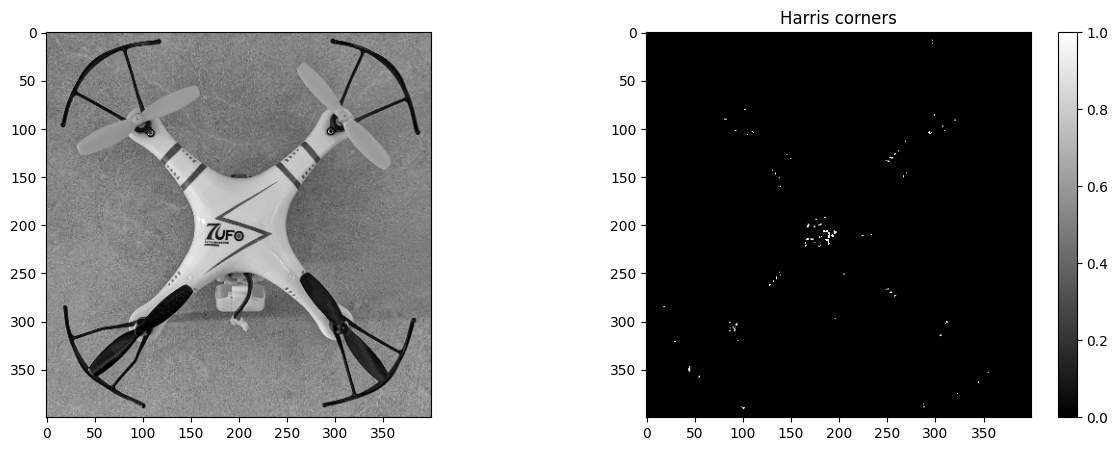

In [42]:
harris_response = cv2.cornerHarris(im_gray,blockSize=2,ksize=3,k=0.04)
# Pick all the corners greater than 1 % of the strongest corner response
corners_thresholded = harris_response>0.05*harris_response.max() 

corners_x,corners_y = np.where(corners_thresholded) # coordinates of corners

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_gray,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(corners_thresholded,cmap='gray')
plt.title('Harris corners')
plt.colorbar()
plt.show()


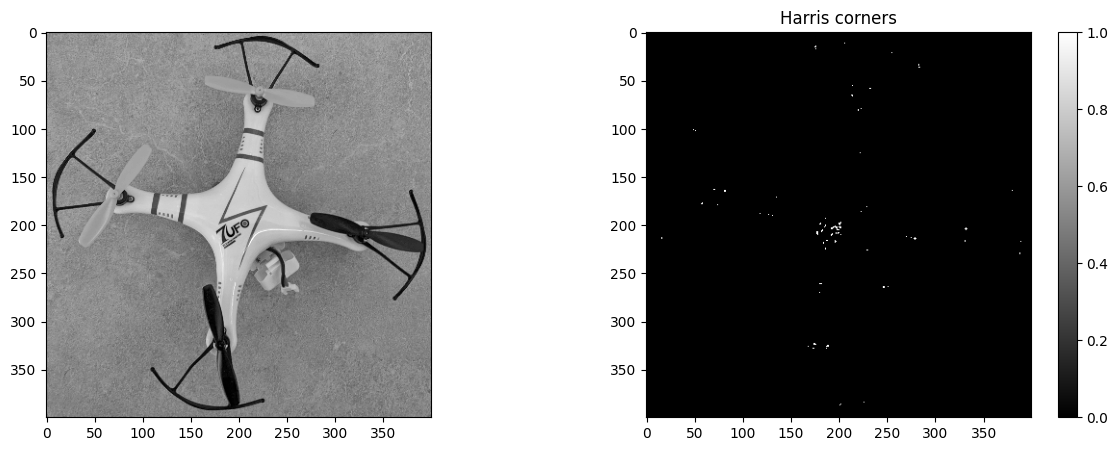

In [44]:
# Let's load in another image of the same drone, taken from a slightly different viewpoint
im_gray_2 = cv2.cvtColor(cv2.resize(cv2.imread('../test_images/Drone_2.jpg'),(400,400)), cv2.COLOR_BGR2GRAY)
harris_response_2 = cv2.cornerHarris(im_gray_2,blockSize=2,ksize=3,k=0.04)
# Pick all the corners greater than 1 % of the strongest corner response
corners_thresholded_2 = harris_response_2>0.05*harris_response.max() 

corners_x_2,corners_y_2 = np.where(corners_thresholded_2) # coordinates of corners

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_gray_2,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(corners_thresholded_2,cmap='gray')
plt.title('Harris corners')
plt.colorbar()
plt.show()

Lets crop a 80x80 patch around the 50th corner in the second image. 

In [45]:
def get_patch(im,x,y,w=10):
    
    patch = im[x-w:x+w,y-w:y+w]
    return patch

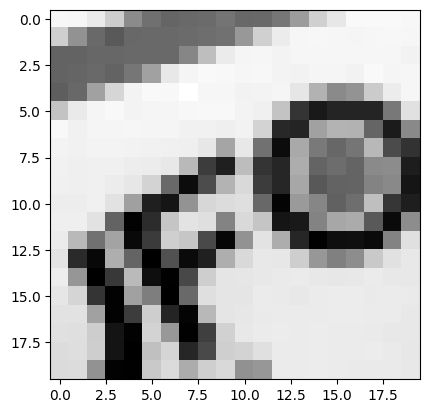

In [46]:
pos_x = corners_x_2[50]
pos_y = corners_y_2[50]
test_patch = get_patch(im_gray_2,pos_x,pos_y)
plt.imshow(test_patch,cmap='gray')
plt.show()

Let's write a function to search for the most similar patch in the original image. We'll use an ssd distance.

In [47]:
def ssd(patch_1,patch_2):
    
    if (patch_1.shape != patch_2.shape): #Ignore patches around the edges 
        return 1e15
    else:
        return np.sum((patch_1-patch_2)**2)

def find_closest_patch(im_to_search, kp_x_to_search, kp_y_to_search, query_patch):
    
    min_dist = 1e15
    min_dist_idx = 0
    # Loop over all corners
    for i in range(len(kp_x_to_search)):
        
        pos_x = kp_x_to_search[i]
        pos_y = kp_y_to_search[i]
        test_patch = get_patch(im_to_search,pos_x,pos_y,w=int(query_patch.shape[0]/2))
        
        dist = ssd(test_patch,query_patch)
        
        if dist <= min_dist:
            min_dist = dist
            min_dist_idx = i
            
    pos_x = kp_x_to_search[min_dist_idx]
    pos_y = kp_y_to_search[min_dist_idx]
        
    return get_patch(im_to_search,pos_x,pos_y), min_dist_idx    

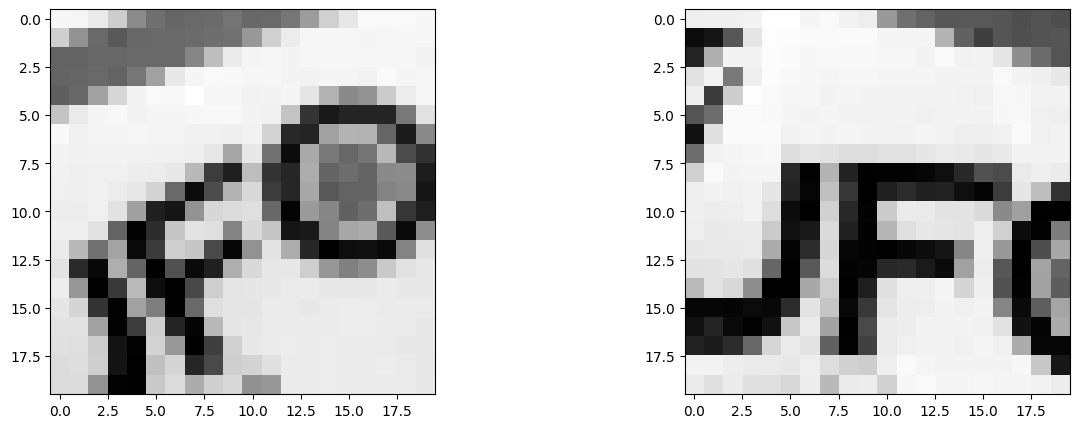

In [48]:
best_patch, patch_idx = find_closest_patch(im_gray,corners_x,corners_y,test_patch)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(test_patch,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(best_patch,cmap='gray')
plt.show()

Not bad, that looks like the same part of the image. Let's see how it does across all possible keypoints

In [49]:
# Loop over all keypoints in image 2, and find closest match in image 1
match_idxs = []
for j in range(len(corners_x_2)):
    pos_x = corners_x_2[j]
    pos_y = corners_y_2[j]
    test_patch = get_patch(im_gray_2,pos_x,pos_y)
    best_patch, patch_idx = find_closest_patch(im_gray,corners_x,corners_y,test_patch)
    match_idxs.append(patch_idx)

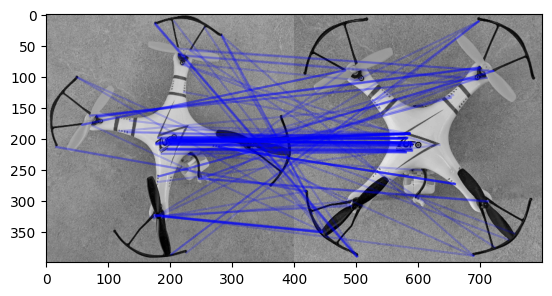

In [50]:
def plot_matches(kpx_1,kpy_1,kpx_2,kpy_2,jump=100):
    plt.plot([kpy_1,kpy_2+jump],[kpx_1,kpx_2],'b',alpha=0.2)

im_both = np.hstack((im_gray_2,im_gray)) # Concatenate images
plt.imshow(im_both,cmap='gray')
for j in range(len(match_idxs)):
    kpx_1 = corners_x_2[j]
    kpy_1 = corners_y_2[j]
    
    kpx_2 = corners_x[match_idxs[j]]
    kpy_2 = corners_y[match_idxs[j]]
    plot_matches(kpx_1,kpy_1,kpx_2,kpy_2,jump=im_gray.shape[0])
plt.show()

## Activity 3: Image Invariances

Hmm, look like there are some ok looking matches, but quite a few incorrect ones.

Why do you think this is? Think about the sum of squared distances error and why it may fail to measure the similarity between image patches.

Try to list some causes of variation that could influence this matching.

answers:
- lighting changes
- ???